# Download Daymet

In [1]:
%load_ext autoreload
%autoreload 2

Daymet provides gridded meteorological data for North American at 1km spatial resolution with daily timestep from 1980 ~ present. [website](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1328) and [user guide](https://daac.ornl.gov/DAYMET/guides/Daymet_V3_CFMosaics.html)

Available variables:

| Variable | Description (units) |
| ---- | ---- |
| tmax | Daily maximum 2-meter air temperature (°C) |
| tmin | Daily minimum 2-meter air temperature (°C) |
| prcp | Daily total precipitation (mm/day) |
| srad | Incident shortwave radiation flux density (W/m2) |
| vp   | Water vapor pressure (Pa) |
| swe  | Snow water equivalent (kg/m2) |
| dayl | Duration of the daylight period (seconds) |

Notes:
 - The Daymet calendar is based on a standard calendar year. All Daymet years, including leap years, have 1 - 365 days. For leap years, the Daymet database includes leap day (February 29) and values for December 31 are discarded from leap years to maintain a 365-day year.
 
 - DayMet's incident shortwave radiation is the "daylit" radiation.  To get the daily average radiation, one must multiply by daylit fraction, given by dayl / 86400.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [3]:
import logging
import numpy as np
import rasterio
import fiona
import os

import watershed_workflow
import watershed_workflow.ui
import watershed_workflow.sources.manager_daymet
import watershed_workflow.daymet
import watershed_workflow.io

watershed_workflow.ui.setup_logging(1,None)

In [4]:
watershed_shapefile = 'Coweeta/input_data/coweeta_basin.shp'

## import watershed

In [5]:
crs, watershed = watershed_workflow.get_split_form_shapes(watershed_shapefile)
logging.info(f'crs: {crs}')

bounds = watershed.exterior().bounds
print(bounds)
print(bounds[2] - bounds[0], bounds[3] - bounds[1])

2022-12-13 17:22:35,457 - root - INFO: 
2022-12-13 17:22:35,458 - root - INFO: Loading shapes
2022-12-13 17:22:35,459 - root - INFO: ------------------------------
2022-12-13 17:22:35,460 - root - INFO: Loading file: 'Coweeta/input_data/coweeta_basin.shp'
2022-12-13 17:22:35,474 - root - INFO: ... found 1 shapes
2022-12-13 17:22:35,475 - root - INFO: Converting to shapely
2022-12-13 17:22:35,481 - root - INFO: crs: epsg:26917


(273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
5169.823952139821 5114.149196119979


## Download

returned raw data has `dim(nband, ncol, nrow)`

In [6]:
startdate = "1980-1-1"
enddate = "1981-1-1"

In [7]:
# setting vars = None to download all available variables
source = watershed_workflow.sources.manager_daymet.FileManagerDaymet()
data = source.get_data(bounds, crs, startdate, enddate)

2022-12-13 17:22:35,563 - root - INFO: Collecting DayMet file to tile bounds: [-83.4889, 35.017, -83.4109, 35.0842]
2022-12-13 17:22:35,565 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_tmin_1980_35.0842x-83.4889_35.0170x-83.4109.nc
2022-12-13 17:22:35,566 - root - INFO: Collecting DayMet file to tile bounds: [-83.4889, 35.017, -83.4109, 35.0842]
2022-12-13 17:22:35,567 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_tmax_1980_35.0842x-83.4889_35.0170x-83.4109.nc
2022-12-13 17:22:35,568 - root - INFO: Collecting DayMet file to tile bounds: [-83.4889, 35.017, -83.4109, 35.0842]
2022-12-13 17:22:35,570 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_prcp_1980_35.0842x-83.4889_35.0170x-83.4109.nc
2022-12-13 17:22:35,571 - root - INFO: Collecting DayMet file to tile bounds: [-83.4889, 35.017, -83.4109, 35.0842]
20

## Reproject Daymet CRS

Reproject daymet CRS to the same as the watershed. This is necessary if watershed meshes are using watershed CRS.

In [8]:
data_new = watershed_workflow.warp.state(data, dst_crs=crs)

## plot Daymet

/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_DEV-2022-08-29-lai/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
2022-12-13 17:22:36,092 - root - INFO: BOUNDS: (1440750.0, -652000.0, 1448750.0, -643000.0)
2022-12-13 17:22:36,103 - root - INFO: BOUNDS: (271527.7143081544, 3875905.0810883655, 281752.1159530128, 3887058.9737918475)


Text(0.5, 1.0, 'Reprojected Daymet')

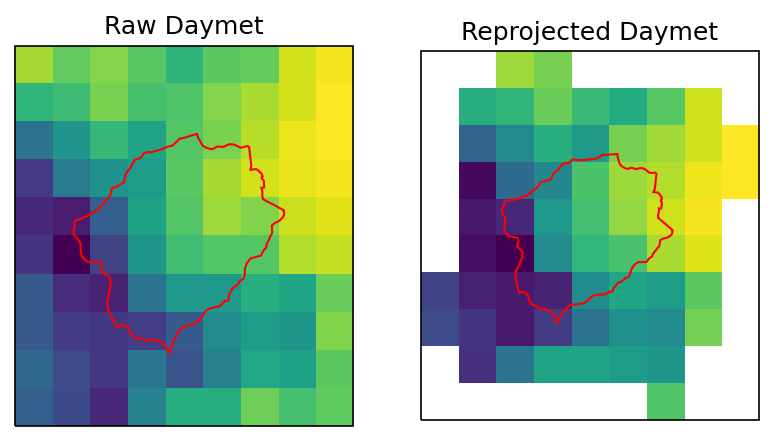

In [9]:
ivar = 'tmax'
islice = 100
daymet_crs = watershed_workflow.crs.daymet_crs()

fig = plt.figure()
ax1 = watershed_workflow.plot.get_ax(daymet_crs, fig, 1, 2, 1)
ax2 = watershed_workflow.plot.get_ax(crs, fig, 1, 2, 2)

watershed_ext_daymet = watershed_workflow.warp.shply(watershed.exterior(),
                                                     crs, daymet_crs)
watershed_workflow.plot.raster(data[ivar].profile, data[ivar].data[islice,:,:], ax1)
watershed_workflow.plot.shply(watershed_ext_daymet, daymet_crs, ax=ax1, color='r')

watershed_workflow.plot.raster(data_new[ivar].profile, data_new[ivar].data[islice,:,:], ax2)
watershed_workflow.plot.hucs(watershed, crs, ax=ax2, color='r')

ax1.set_title("Raw Daymet")
ax2.set_title("Reprojected Daymet")



# save daymet

## Write to HDF5

Write raw daymet data to a single HDF5 file.

In [10]:
assert(len(data_new.collections) == 1)
met_data = data_new.collections[0]

filename = os.path.join('Coweeta','output_data', 'watershed_daymet-raw.h5')
watershed_workflow.io.write_dataset_to_hdf5(
    filename,
    met_data, 
    watershed_workflow.daymet.getAttributes(bounds, startdate, enddate))

2022-12-13 17:22:36,318 - root - INFO: Writing HDF5 file: Coweeta/output_data/watershed_daymet-raw.h5


## Write to ATS format

This will write daymet in a format that ATS can read. E.g., this will partition precipitation into rain and snow, convert vapor pressure to relative humidity, get mean air temperature and so on.

- dout has dims of `(ntime, nrow, ncol)` or `(ntime, ny, nx)`

In [11]:
met_data_ats = watershed_workflow.daymet.daymet_to_daily_averages(met_data)

filename = os.path.join('Coweeta', 'output_data', 'watershed_daymet-ats.h5')
watershed_workflow.io.write_dataset_to_hdf5(
    filename,
    met_data_ats,
    watershed_workflow.daymet.getAttributes(bounds, startdate, enddate))
    

2022-12-13 17:22:37,011 - root - INFO: Converting to ATS met input
2022-12-13 17:22:37,014 - root - INFO: Writing HDF5 file: Coweeta/output_data/watershed_daymet-ats.h5
